__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: 09/21/20
- Instructor name: Abhineet Kulkarni
- Blog post URL: [Link Here](https://thomaskbrown18.github.io/sentiment_analysis_on_financial_news_headlines)

__Project Description:__<br><br>
The purpose of this project is to build an artificial neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms in order to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  You could think of it as another type of stock ticker, but for tracking sentiment instead of stock price.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,846 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  positive   
1  positive   
2  neutral    
3  neutral    
4  positive   

                                                                                                                                     Headline  
0  Finnish P+¦yry has been awarded an engineering contract by CFR , the national railway company of Romania .                                  
1  The developers of that project predict that once it is completed in April 2009 , Skanssi will attract some 4.5 million visitors annually .  
2  Yesterday , Legrand issued its E300 million fixed rate deal maturing 2017 .                                                                 
3  The Point Village , designed by Scott Tallon Walker , will include a shopping center , office premises , a hotel and a cinema .             
4  In 2008 , the deal is likely to bring savings of EUR 20mn-25mn .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on. Due to a low number of negative articles compared to the rest, I'll be treating this as a binary problem: 'Positive' vs 'Not Positive'.  Another advantage to this approach is that instead of a ternary classification problem, the neural network outputs one value, from 0 to 1, with 1 being positive and 0 being negative.  This allows for a gradient of sentiment.<br><br>
For example, a headline that's moderately positive should get a sentiment value of .75.  This can allow for a bit more nuance in terms of evaluation later on, especially when we examine individual headlines.

- 0 is Negative or Neutral
- 1 is Positive

In [4]:
# BINARY
df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  1           

                                                                                                                                     Headline  
0  Finnish P+¦yry has been awarded an engineering contract by CFR , the national railway company of Romania .                                  
1  The developers of that project predict that once it is completed in April 2009 , Skanssi will attract some 4.5 million visitors annually .  
2  Yesterday , Legrand issued its E300 million fixed rate deal maturing 2017 .                                                                 
3  The Point Village , designed by Scott Tallon Walker , will include a shopping center , office premises , a hotel and a cinema .             
4  In 2008 , the deal is likely to bring savings of EUR 20mn-25mn .

## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  

In [5]:
stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [6]:
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  1           

                                                                                          Headline  
0  finnish p+¦yry awarded engineering contract cfr national railway company romania                 
1  developers project predict completed april 2009 skanssi attract 4.5 million visitors annually    
2  yesterday legrand issued e300 million fixed rate deal maturing 2017                              
3  point village designed scott tallon walker include shopping center office premises hotel cinema  
4  2008 deal likely bring savings eur 20mn-25mn

## Lemmatization:

Lemmatization will change a word like 'Running' into 'run'.  This simplification of the words makes it possible for the neural network later on to treat 'Running', 'run', 'ran', and 'runs' exactly the same, for example.  You lose some nuance in the sentence as you'll soon see, but it makes it much easier for the model to learn in the end.  Below are some headlines after lemmatization:

In [7]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [9]:
# Still looking good
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  1           

                                                                                       Headline  
0  finnish p+¦yry award engineering contract cfr national railway company romania                
1  developer project predict complete april 2009 skanssi attract 4.5 million visitor annually    
2  yesterday legrand issue e300 million fix rate deal mature 2017                                
3  point village design scott tallon walker include shopping center office premise hotel cinema  
4  2008 deal likely bring saving eur 20mn-25mn

# EDA:

In [10]:
# Let's start by exploring sentence length vs sentiment:
df_eda = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                     encoding='latin-1')
df_eda = df_eda.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df_eda['Sentiment'] = df_eda['Sentiment'].map(lambda x: 'positive' if x == 'positive' else 'neutral/neg')
# Same dataset as before:

In [11]:
sent_len = []
for row in df_eda.Headline:
    x = (len(row.split()))
    sent_len.append(x)
    
df_eda['Sentence_Length'] = sent_len

In [12]:
df_eda.head()

Sentiment  \
0  neutral/neg   
1  positive      
2  neutral/neg   
3  neutral/neg   
4  neutral/neg   

                                                                                                                                                                                                                                                         Headline  \
0  The orders consist in total of over 1,600 panels of lift-away weatherdeck hatch covers and they will be delivered for container vessels with capacities ranging from 2,000 to 13,300 TEUs .                                                                      
1  Ruukki 's delivery volumes and selling prices showed favourable development and the company 's comparable net sales grew by 50 % year-on-year to EUR647m , CEO Sakari Tamminen said .                                                                            
2  Tekla Group 's net sales for 2005 were approximately 38 million euros .                                                                                                                                                                                          
3  FinancialWire ( tm ) , in cooperation with the Investrend Broadcast Syndicate , also provides complete , daily conference call and webcast schedules as a service to shareholders and investors via the FirstAlert ( tm ) Networks oeFirstAlert ( tm ) Daily .   
4  The newly-completed Allure of the Seas and its identical sister ship , Oasis of the Seas , which was completed last year are the world 's largest cruise ships .                                                                                                 

   Sentence_Length  
0  31               
1  30               
2  13               
3  43               
4  30

In [13]:
df_pos = df_eda[df_eda['Sentiment'] == 'positive']
df_neg = df_eda[df_eda['Sentiment'] == 'neutral/neg']

Positive Headlines - Green, and Negative/Neutral Headlines - Blue


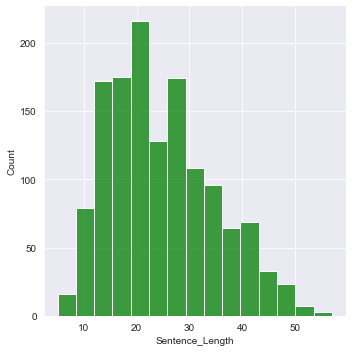

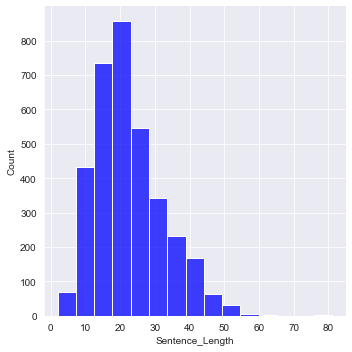

In [14]:
print ('Positive Headlines - Green, and Negative/Neutral Headlines - Blue') 
sns.displot(df_pos, x = 'Sentence_Length', color = 'g', bins = 15)
sns.displot(df_neg, x = 'Sentence_Length', color = 'b', bins = 15);

Positive headlines (Green) appear to more commonly be longer, but it's a bit too close to tell for certain.

Let's explore some word clouds to see the most commonly occurring words for each label.

In [15]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [16]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    ###
    

Positive Sentiment Wordcloud:


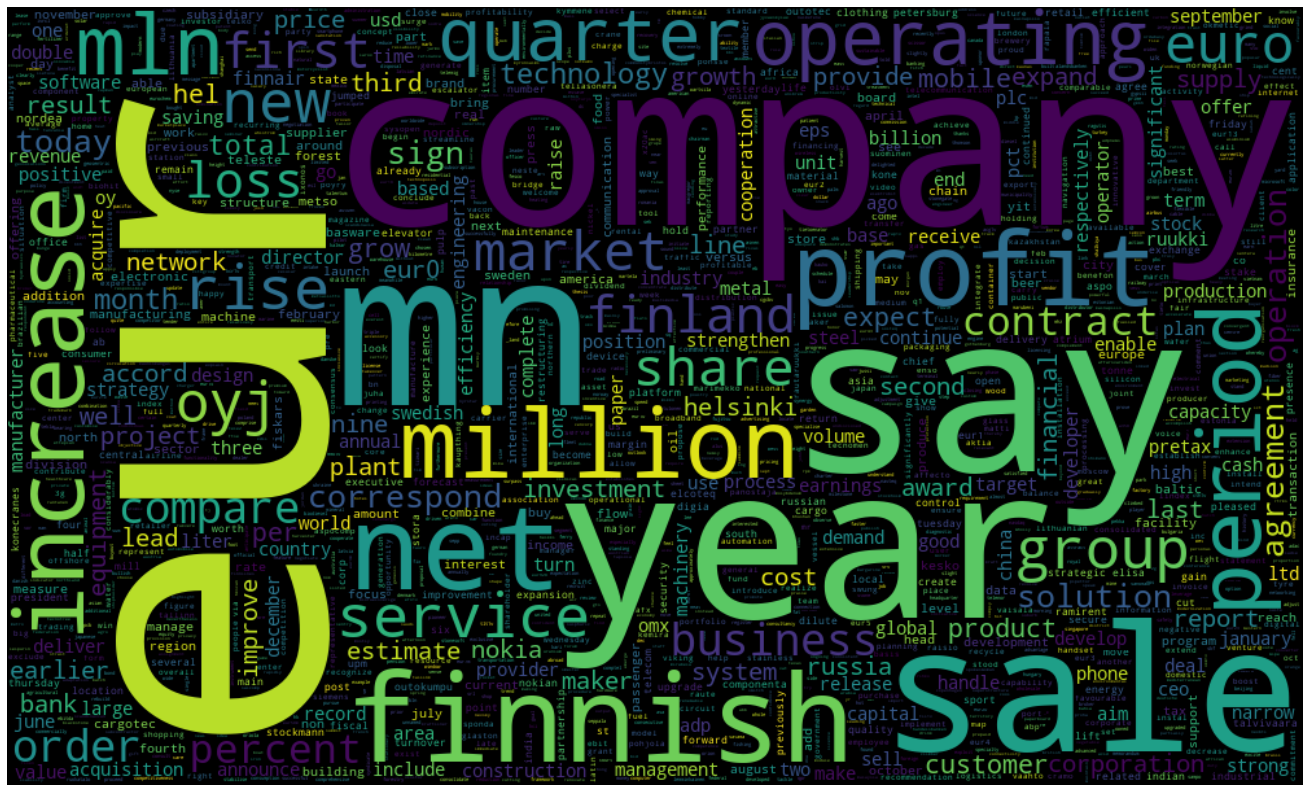

Negative Sentiment Wordcloud:


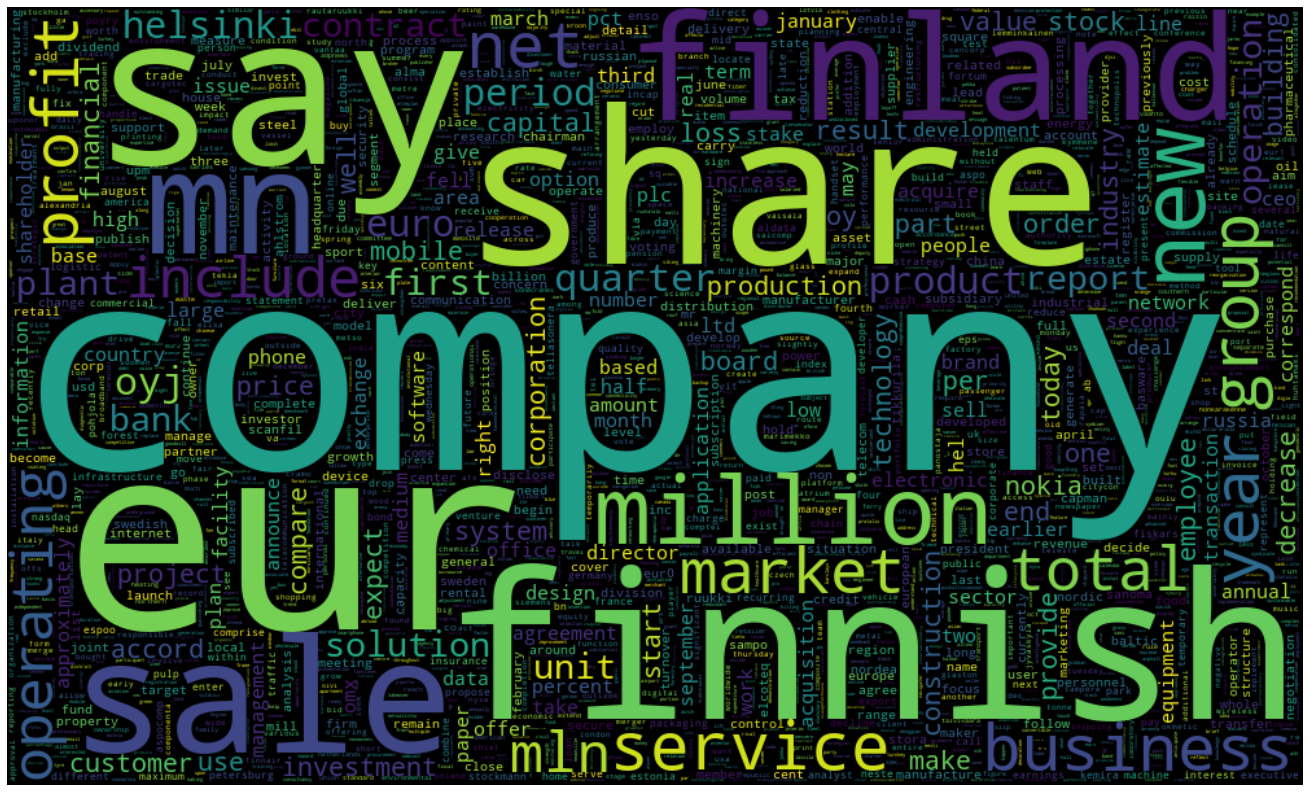

In [17]:
# Showing Word Clounds
show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'

In [18]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [19]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

Sentiment  \
0  1           
1  1           
2  0           
3  0           
4  1           

                                                                                       Headline  
0  p+¦yry award engineering contract cfr national railway romania                                
1  developer project predict complete april 2009 skanssi attract 4.5 million visitor annually    
2  yesterday legrand issue e300 million fix rate deal mature 2017                                
3  point village design scott tallon walker include shopping center office premise hotel cinema  
4  2008 deal likely bring saving eur 20mn-25mn

In [20]:
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]


Positive Sentiment Wordcloud:


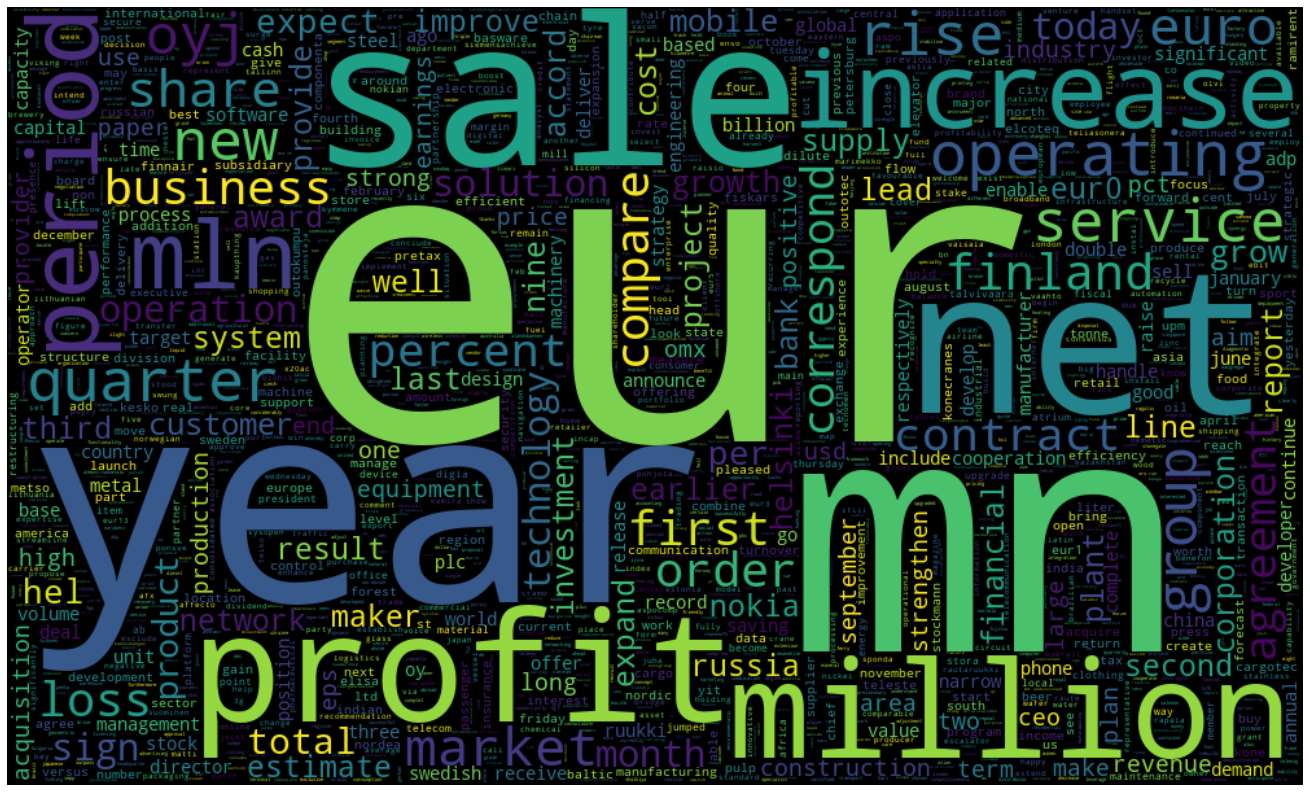

Negative Sentiment Wordcloud:


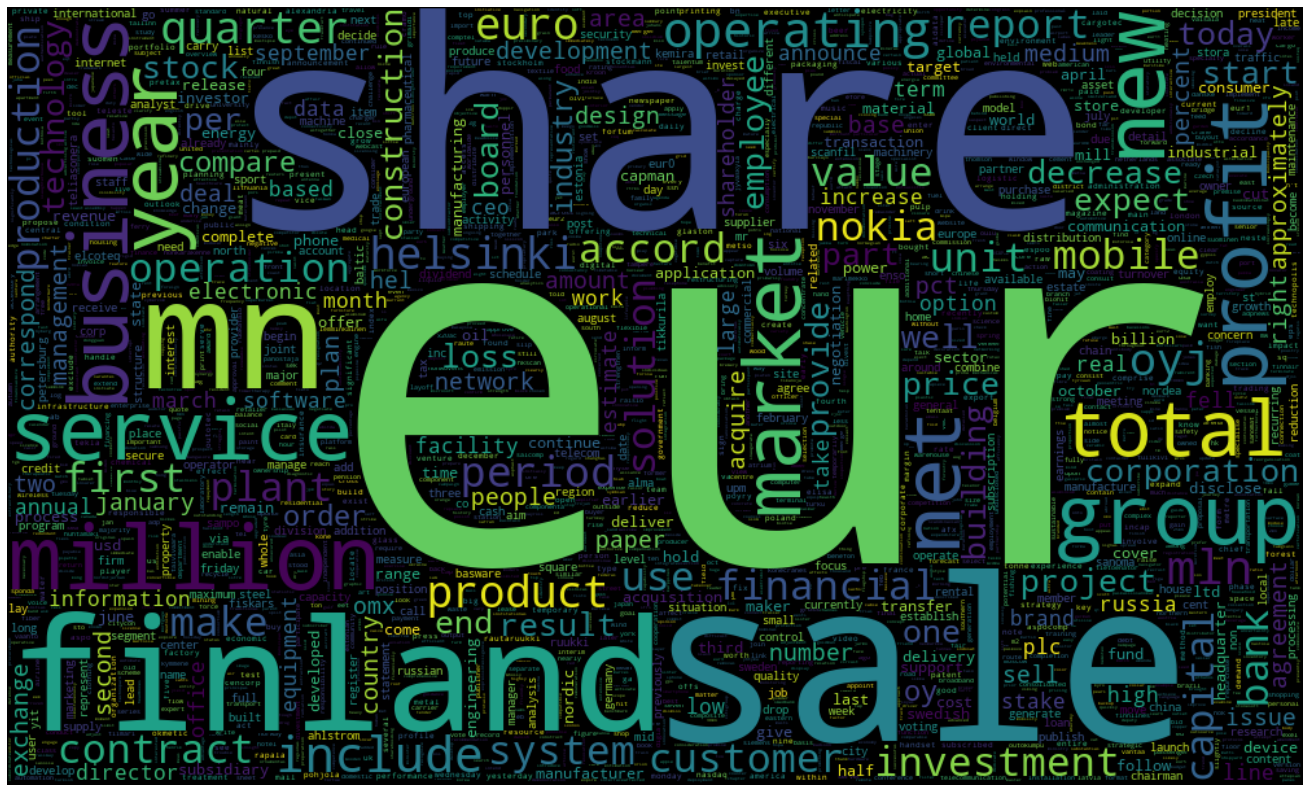

In [21]:
# Showing Word Clounds with additional words removed
show_wordclouds()

# Counter:

In [22]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [23]:
text = df.Headline
counter = counter_word(text)

In [24]:
len(counter) # Number of words in the vocabulary of these texts

10078

In [25]:
# showing the first 25 rows of the counter
n = 25
out = dict(list(counter.items())[0: n])  
out

{'p+¦yry': 1,
 'award': 41,
 'engineering': 55,
 'contract': 177,
 'cfr': 1,
 'national': 17,
 'railway': 8,
 'romania': 6,
 'developer': 34,
 'project': 124,
 'predict': 1,
 'complete': 58,
 'april': 44,
 '2009': 297,
 'skanssi': 1,
 'attract': 4,
 '4.5': 16,
 'million': 441,
 'visitor': 5,
 'annually': 8,
 'yesterday': 25,
 'legrand': 1,
 'issue': 72,
 'e300': 1,
 'fix': 23}

In [26]:
num_words = len(counter)

# Train/Test Split:

In [27]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [28]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [29]:
# Train Test Split:
# Already shuffled, so we're good to go
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [30]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

['p+¦yry award engineering contract cfr national railway romania',
 'developer project predict complete april 2009 skanssi attract 4.5 million visitor annually',
 'yesterday legrand issue e300 million fix rate deal mature 2017']

[1, 1, 0]

# Tokenization:

Tokenization is an important step of the process.  It creates a number coded to each word in the vocabulary.  This way, the neural network is able to build patterns and learn meaning.  Examples of the process can be seen below.  <br><br>
In order to keep all headlines the same length, I'm creating a max length of 50 words (only a handful of headlines are longer), and a sentence that is shorter than that will be filled for the remainder with 0s.  This process is called padding.

In [31]:
vocab_size = len(counter) # approx 1/5 of the words 
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [32]:
# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)

In [33]:
# Switch to Numpy Array
# Necessary for the ANN to read the data
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [34]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [ 484 2064  129 2593 3736 3737   41  802  356  175 1008 1009 2594    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 point village design scott tallon walker include shopping center office premise hotel cinema

Label:
 0


## Taking a Look at Inputs:

In [35]:
# Looks good.  Just making sure everything is getting transformed correctly:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'p+¦yry award engineering contract cfr national railway romania'

-----------------


array([ 392, 3730,  294,  196,   44, 3731,  762, 1358, 1743,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


1

-----------------


'airbus 100 firm order a350 89 nonbinding commitment'

-----------------


array([3052,  288,  419,   56, 6688, 1182,    1, 1203,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


1

-----------------


In [36]:
# Making sure all our process hasn't shuffled anything and we can still decode. . . 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '-') for i in text])

print(decode_sentence(training_padded[1]))
print(training_headlines[1])
print(labels[1])

developer project predict complete april 2009 skanssi attract 4 5 million visitor annually - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
developer project predict complete april 2009 skanssi attract 4.5 million visitor annually
1


# Modeling:

## Baseline with Vader:

Vader is a commonly used sentiment analysis toolbox.  Let's see if we can use it as a baseline against the artificial neural network I'll build later on in the notebook.

In [37]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [38]:
# Vader Accuracy:
# Making a new dataframe to mess around in:
df2 = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df2 = df2.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df2['Sentiment'] = df2['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df2['vader_sent'] = 0 # Placeholder as 0
df2 = df2[['Sentiment', 'vader_sent', 'Headline']]
df2.head()

Sentiment  vader_sent  \
0  0          0            
1  1          0            
2  0          0            
3  0          0            
4  1          0            

                                                                                                                                                                 Headline  
0  Cramo is a service company specialising in construction machinery and equipment rental and rental-related services , as well as the rental and sale of modular space .  
1  The company will make its marketing and sales investments initiated in 2009 even more efficient in 2010 .                                                               
2  As part of the reorganization , Kauko-Telko Ltd will be divided into Telko Ltd , Leipurin Ltd , Hamina Terminal Services Ltd and Kaukomarkkinat Ltd. .                  
3  Compared with the FTSE 100 index , which rose 51.5 points ( or 0.9 % ) on the day , this was a relative price change of -0.6 % .                                        
4  The costs of the new ropax vessels are 30 % lower than those of the present ones .

In [39]:
# Sanity check:
x = sid.polarity_scores('This is a very bad sentence!')
print (x)
print (x['compound'])

{'neg': 0.472, 'neu': 0.346, 'pos': 0.182, 'compound': -0.5433}
-0.5433


In [40]:
vader_sent_list = []
for row in df2.Headline:
    x = sid.polarity_scores(row)['compound']
    vader_sent_list.append(x)
    
df2.vader_sent = vader_sent_list
df2.head()
# Looks good, but we'll need to change vader_sent to the same format as Sentiment
# The 'Compound' score we're using uses a scale of -1 to 1, while Sentiment is 0 to 1

Sentiment  vader_sent  \
0  0          0.2732       
1  1          0.4754       
2  0          0.0000       
3  0          0.0000       
4  1         -0.2960       

                                                                                                                                                                 Headline  
0  Cramo is a service company specialising in construction machinery and equipment rental and rental-related services , as well as the rental and sale of modular space .  
1  The company will make its marketing and sales investments initiated in 2009 even more efficient in 2010 .                                                               
2  As part of the reorganization , Kauko-Telko Ltd will be divided into Telko Ltd , Leipurin Ltd , Hamina Terminal Services Ltd and Kaukomarkkinat Ltd. .                  
3  Compared with the FTSE 100 index , which rose 51.5 points ( or 0.9 % ) on the day , this was a relative price change of -0.6 % .                                        
4  The costs of the new ropax vessels are 30 % lower than those of the present ones .

In [41]:
# Greater than 50% (i.e. 0 or neutral) on the vader compound score gets it. . . 
# . . . classified as a 1 i.e. 'positive' on our scale
df2['vader_sent'] = df2['vader_sent'].map(lambda x: 1 if x > 0 else 0)
df2.head()

Sentiment  vader_sent  \
0  0          1            
1  1          1            
2  0          0            
3  0          0            
4  1          0            

                                                                                                                                                                 Headline  
0  Cramo is a service company specialising in construction machinery and equipment rental and rental-related services , as well as the rental and sale of modular space .  
1  The company will make its marketing and sales investments initiated in 2009 even more efficient in 2010 .                                                               
2  As part of the reorganization , Kauko-Telko Ltd will be divided into Telko Ltd , Leipurin Ltd , Hamina Terminal Services Ltd and Kaukomarkkinat Ltd. .                  
3  Compared with the FTSE 100 index , which rose 51.5 points ( or 0.9 % ) on the day , this was a relative price change of -0.6 % .                                        
4  The costs of the new ropax vessels are 30 % lower than those of the present ones .

In [42]:
# Score counter for accuracy:
# 1 for correct sentiment, 0 for no match
df2['vader_sent_match'] = 1 - abs(df2['vader_sent'] - df2['Sentiment'])
df2 = df2[['Sentiment', 'vader_sent', 'vader_sent_match', 'Headline']]
df2.head(10)

Sentiment  vader_sent  vader_sent_match  \
0  0          1           0                  
1  1          1           1                  
2  0          0           1                  
3  0          0           1                  
4  1          0           0                  
5  1          1           1                  
6  1          1           1                  
7  0          0           1                  
8  1          0           0                  
9  1          1           1                  

                                                                                                                                                                                                                                                    Headline  
0  Cramo is a service company specialising in construction machinery and equipment rental and rental-related services , as well as the rental and sale of modular space .                                                                                     
1  The company will make its marketing and sales investments initiated in 2009 even more efficient in 2010 .                                                                                                                                                  
2  As part of the reorganization , Kauko-Telko Ltd will be divided into Telko Ltd , Leipurin Ltd , Hamina Terminal Services Ltd and Kaukomarkkinat Ltd. .                                                                                                     
3  Compared with the FTSE 100 index , which rose 51.5 points ( or 0.9 % ) on the day , this was a relative price change of -0.6 % .                                                                                                                           
4  The costs of the new ropax vessels are 30 % lower than those of the present ones .                                                                                                                                                                         
5  Basware Corporation stock exchange release August 31 , 2010 at 16:25 Basware signed a large deal with an international industrial group Basware will deliver Invoice Automation solution and Connectivity Services to an international industrial group .  
6  Profit after taxes was EUR 0.1 mn , compared to EUR -0.4 mn the previous year .                                                                                                                                                                            
7  ALEXANDRIA , Va. , Nov. 5 -- Risto Kontturi of Rajamaki , Finland , and Jari Ylinen of Hyvinkaa , Finland , have developed an automated transportation system with a user-controlled transport selection .                                                 
8  Aspo Plc STOCK EXCHANGE RELEASE February 11 , 2011 at8 .45 a.m. ESL Shipping Ltd , part of Aspo Group , has signed a new , long-term contract with Rautaruukki Corporation for the marine transport of raw materials on the Baltic Sea .                   
9  Growth is expected to continue in 2008 .

In [43]:
x = sum(df2['vader_sent_match'])
y = len(df2)
print ('Correct Vader Classifications:', x, 'out of', y)
print ('Percentage Correct:', '{:.2%}'.format(x/y))

Correct Vader Classifications: 3004 out of 4846
Percentage Correct: 61.99%


With the threshold of greater than 50% classified as 'Positive', we got 62% accuracy with Vader.  Let's see if we can do a better job with an artificial neural network.

# Neural Network:

In [44]:
# First let's define the functions for model evaluation:
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

Now it's time to build a baseline neural network:

## Model 1 (1 Hidden Layer):

In [45]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

# Slower learning rate worked better as it kept the learning more stable
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code

In [46]:
num_epochs = 50
# After 5 epochs of validation loss not improving, the model will stop.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 2s 508us/step - loss: 0.6457 - acc: 0.7100 - val_loss: 0.6068 - val_acc: 0.7093
Epoch 2/50
3876/3876 [==============================] - 2s 446us/step - loss: 0.5886 - acc: 0.7211 - val_loss: 0.5944 - val_acc: 0.7093
Epoch 3/50
3876/3876 [==============================] - 2s 444us/step - loss: 0.5819 - acc: 0.7211 - val_loss: 0.5920 - val_acc: 0.7093
Epoch 4/50
3876/3876 [==============================] - 2s 443us/step - loss: 0.5791 - acc: 0.7211 - val_loss: 0.5892 - val_acc: 0.7093
Epoch 5/50
3876/3876 [==============================] - 2s 444us/step - loss: 0.5746 - acc: 0.7211 - val_loss: 0.5859 - val_acc: 0.7093
Epoch 6/50
3876/3876 [==============================] - 2s 445us/step - loss: 0.5698 - acc: 0.7211 - val_loss: 0.5819 - val_acc: 0.7093
Epoch 7/50
3876/3876 [==============================] - 2s 443us/step - loss: 0.5639 - acc: 0.7211 - val_loss: 0.5770 - val_acc: 0.7093
E

### Model Evaluation:

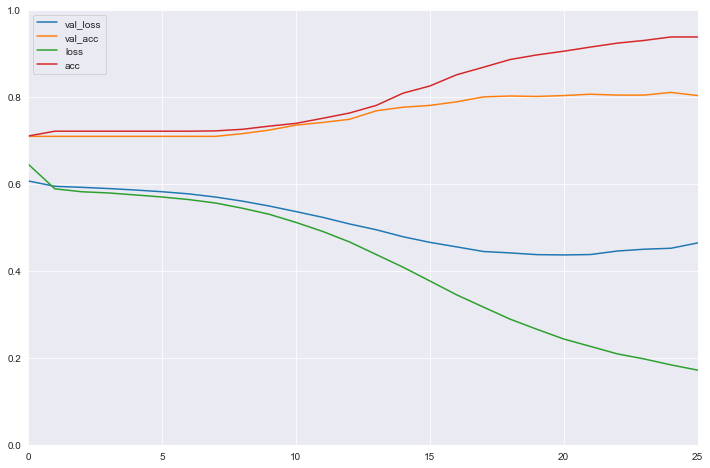

In [47]:
model_eval(history)

In [48]:
model_metrics(model)

Train Loss: 16.149%
Train Accuracy: 94.143%
Test Loss: 46.419%
Test Accuracy: 80.309%


In [49]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.7516836]
 [0.0146654]
 [0.5391313]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.18230689]
 [0.11965434]
 [0.46284467]]


While there's room for improvement with ~81% accuracy, this ended up being my best performing model.  I'm including the following models as well to show some different approaches I tried.

## Model 2 (2 Hidden Layers):

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(50, activation='relu')) # Optional second hidden layer
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) 

In [51]:
num_epochs = 50
# Same early stopping as before  
# 5 seems to be a good number given the slow and steady learning rate.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 2s 526us/step - loss: 0.6500 - acc: 0.7100 - val_loss: 0.6084 - val_acc: 0.7093
Epoch 2/50
3876/3876 [==============================] - 2s 435us/step - loss: 0.5898 - acc: 0.7211 - val_loss: 0.5953 - val_acc: 0.7093
Epoch 3/50
3876/3876 [==============================] - 2s 434us/step - loss: 0.5846 - acc: 0.7211 - val_loss: 0.5927 - val_acc: 0.7093
Epoch 4/50
3876/3876 [==============================] - 2s 434us/step - loss: 0.5799 - acc: 0.7211 - val_loss: 0.5900 - val_acc: 0.7093
Epoch 5/50
3876/3876 [==============================] - 2s 435us/step - loss: 0.5786 - acc: 0.7211 - val_loss: 0.5861 - val_acc: 0.7093
Epoch 6/50
3876/3876 [==============================] - 2s 430us/step - loss: 0.5730 - acc: 0.7211 - val_loss: 0.5815 - val_acc: 0.7093
Epoch 7/50
3876/3876 [==============================] - 2s 433us/step - loss: 0.5645 - acc: 0.7211 - val_loss: 0.5728 - val_acc: 0.7093
E

### Model Evaluation:

In [52]:
model_metrics(model)

Train Loss: 14.008%
Train Accuracy: 95.330%
Test Loss: 48.724%
Test Accuracy: 81.031%


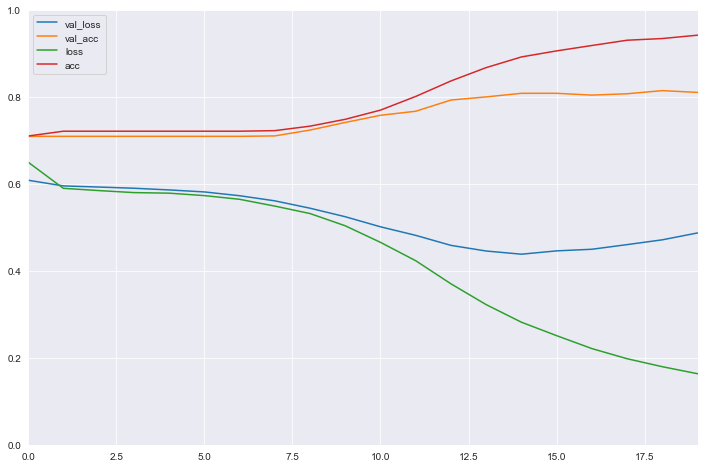

In [53]:
model_eval(history)

In [54]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.8224866 ]
 [0.00932934]
 [0.54870397]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.15351652]
 [0.0660885 ]
 [0.4050431 ]]


## Model 3 (LSTM):

LSTM (Long Short Term Memory) models are quite popular as well for NLP.  Let's give it a try.

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [56]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.6002 - acc: 0.7180 - val_loss: 0.6057 - val_acc: 0.7093
Epoch 2/50
3876/3876 [==============================] - 9s 2ms/step - loss: 0.5880 - acc: 0.7211 - val_loss: 0.6094 - val_acc: 0.7093
Epoch 3/50
3876/3876 [==============================] - 9s 2ms/step - loss: 0.5939 - acc: 0.7211 - val_loss: 0.6081 - val_acc: 0.7093
Epoch 4/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5931 - acc: 0.7211 - val_loss: 0.6028 - val_acc: 0.7093
Epoch 5/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5938 - acc: 0.7211 - val_loss: 0.6041 - val_acc: 0.7093
Epoch 6/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5928 - acc: 0.7211 - val_loss: 0.6057 - val_acc: 0.7093
Epoch 7/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5932 - acc: 0.7211 - val_loss: 0.6057 - val_acc: 0.7093
Epoch 8/50

### Model Evaluation:

In [57]:
model_metrics(model)

Train Loss: 59.196%
Train Accuracy: 72.110%
Test Loss: 60.361%
Test Accuracy: 70.928%


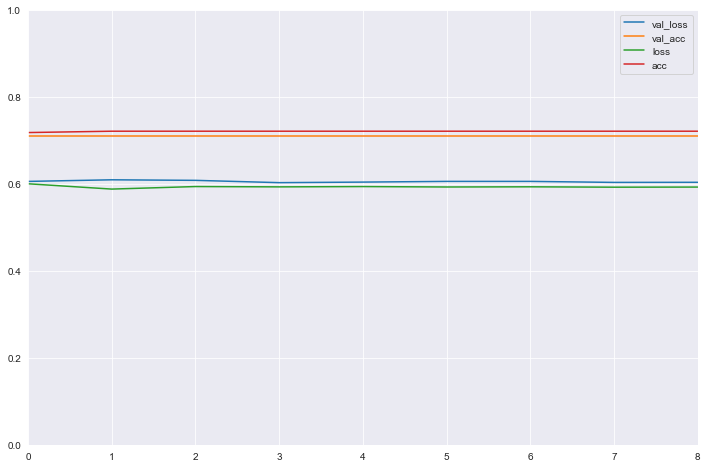

In [58]:
model_eval(history)

In [59]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.27265698]
 [0.2726636 ]
 [0.27265984]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.27266186]
 [0.27266145]
 [0.2726611 ]]


## Transfer Learning with GloVe:

[Source](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

Now, I'll be trying out a pre-trained model called GloVe to prime the embedding layer of this project.  Let's see if we can get better results with this network.

In [60]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [61]:
f = open('/Users/Thomas/Desktop/glove.6B/glove.6B.50d.txt')  
# Enormous download for this file.  
# If you're interested in replicating this code, you can download it yourself. . .  
# . . . and replace the path in this cell

In [62]:
embeddings_index = dict()

In [63]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [64]:
print('Loaded %s word vectors.' % len(embeddings_index))
# Should be enough. . . 

Loaded 400000 word vectors.


In [65]:
# Initializing the matrix for the training set
embedding_matrix = zeros((vocab_size, 50)) # using 50 dimensional vectors
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [66]:
model = Sequential()
e = Embedding(vocab_size, 50, weights = [embedding_matrix], 
              input_length = max_length, 
              trainable=False)

model.add(e) # Adding our embedding layer from earlier
model.add(Flatten())
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(200, activation='relu')) # Adding an additional dense layer like before
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            503900    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               500200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 1,004,301
Trainable params: 500,401
Non-trainable params: 503,900
______________________________________________________________

In [67]:
num_epochs = 100
# Giving this model a bit more patience than the others, just in case. . . 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/100
3876/3876 [==============================] - 1s 378us/step - loss: 0.6026 - acc: 0.6981 - val_loss: 0.5632 - val_acc: 0.7309
Epoch 2/100
3876/3876 [==============================] - 1s 255us/step - loss: 0.4678 - acc: 0.7724 - val_loss: 0.5682 - val_acc: 0.7186
Epoch 3/100
3876/3876 [==============================] - 1s 257us/step - loss: 0.4081 - acc: 0.8148 - val_loss: 0.5830 - val_acc: 0.7196
Epoch 4/100
3876/3876 [==============================] - 1s 254us/step - loss: 0.3450 - acc: 0.8537 - val_loss: 0.6023 - val_acc: 0.7124
Epoch 5/100
3876/3876 [==============================] - 1s 252us/step - loss: 0.2918 - acc: 0.8808 - val_loss: 0.6161 - val_acc: 0.7289
Epoch 6/100
3876/3876 [==============================] - 1s 255us/step - loss: 0.2473 - acc: 0.9035 - val_loss: 0.6625 - val_acc: 0.7299
Epoch 7/100
3876/3876 [==============================] - 1s 253us/step - loss: 0.1973 - acc: 0.9288 - val_loss: 0.6856 - val_acc: 0

### Model Evaluation:

In [68]:
model_metrics(model)

Train Loss: 4.613%
Train Accuracy: 99.536%
Test Loss: 78.535%
Test Accuracy: 71.649%


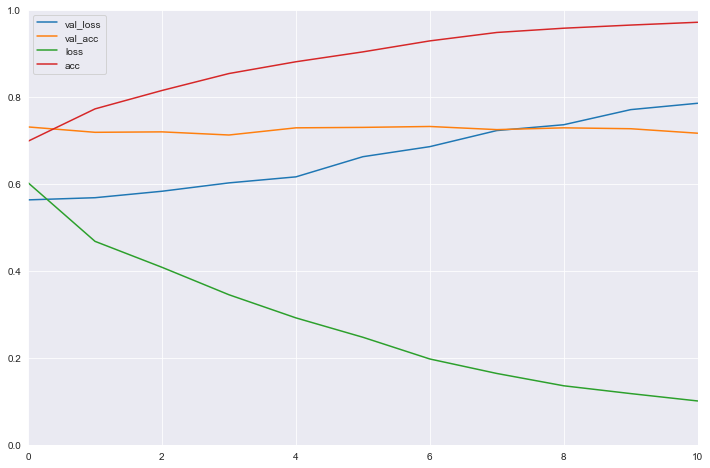

In [69]:
model_eval(history)

In [70]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.8210035 ]
 [0.00338998]
 [0.02208771]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.4593296 ]
 [0.38791952]
 [0.3570375 ]]


Surprisingly, I did not get great performance with this model.  The original embedded layer model worked best.  Validation loss was not kept under control.  Adding dropout layers to help with regularization helped a bit, but not enough.

## Embedding Dimensions:

With the following code, I can download the embedding vectors weights and metadata in order to upload to TensorFlow Projector.  The website is found [here](https://projector.tensorflow.org/), and if you un-comment the following code, run it, download the files, upload them to the projector, and click 'spherize data' you can see the embeddings from the neural network.

An example of this can be found in the gif in the readme file.

In [71]:
'''
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\ne = model.layers[0]\nweights = e.get_weights()[0]\nprint(weights.shape) # shape: (vocab_size, embedding_dim)\n\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.  It would be great to have a website where individuals or firms could keep track of products, companies, or industries they're interested in keeping track of.
- Other neural network architecture types.  I think there's more work to do on LSTM models, GRU models, or other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.  There are more ways of breaking down texts aside from positive vs negative.  It would be interesting to break down some of these divisions.  
- Rate different newspapers by sentiment value.  I think it would also be fun to see which newspapers have the most positive tone!  A more accurate model, more labeled data, and more training could make this very doable.

# Conclusion:

If I were to put this into production, I would use the first embedded layer model and train it with quite a bit more data.  It would be a challenge to collect, but the model would be able to gain quite a bit more accuracy.  In the end, though, I believe it would ultimately be worth it.

This was a fun challenge.  Sentiment analysis is a fairly tried and true field of study, but it was a bit more of a challenge to try it with financial news headlines.  The words that impart sentiment tend to be much different than those in (for example) Amazon reviews or other common test cases.  

While ~81% accuracy has some definite room for improvement, it's not a bad start considering the amount of labeled data that was available for this project.  At some point, I'd love to come back to this with a larger dataset and more experience under my belt working with neural networks and take another crack at this project.

Thanks for reading, and let me know if you have any questions.

-Thomas